In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.signal import savgol_filter
from lmfit import Minimizer, Parameters, create_params, report_fit, Model
import os
import sys
sys.path.append('../src')
import json

In [2]:
from SQ_KAN import *

## P(Q)

def hardsphere(q, sigma=1):
    R = sigma / 2
    P = (3 * (np.sin(q * R) - q * R * np.cos(q * R)) / (q * R) ** 3) ** 2
    return P

def fuzzysphere(q, sigma=1, sigma_f=0.1):
    R = sigma / 2
    P = (3 * (np.sin(q * R) - q * R * np.cos(q * R)) / (q * R) ** 3) ** 2 * np.exp(-(sigma_f * sigma * q) ** 2 / 2)
    return P

def log_normal_pdf(mu, sigma, x):
    return np.exp(-(np.log(x) - mu) ** 2 / 2 / sigma ** 2) / x / sigma

def P_HS_eff(q, sigma=1, d_sigma=0.05, return_f=False):
    '''
    sigma: average particle size
    d_sigma: polydispersity
    return_f: toggle whether to return the particle size distribution
    '''
    # List of particle diameter
    n_sample = 101
    sigma_list = (1 + np.linspace(-5, 5, n_sample) * d_sigma) * sigma
    sigma_list = sigma_list[sigma_list > 0]

    # Size distribution
    f_sigma = log_normal_pdf(0, d_sigma, sigma_list / sigma)
    p_sigma = f_sigma * (sigma_list / sigma) ** 6

    # Calculate effective P(Q)
    P_eff = np.zeros_like(q)
    for i in range(len(sigma_list)):
        P_i = hardsphere(q, sigma_list[i]) * p_sigma[i]
        P_eff = P_eff + P_i

    P_eff = P_eff / np.sum(p_sigma)

    if return_f:
        return P_eff, sigma_list, f_sigma
    else:
        return P_eff
    
def P_fuzzy_eff(q, sigma, d_sigma):
    P_eff = fuzzysphere(q, sigma, d_sigma)
    return P_eff

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))
Device set to: cpu
All relevant tensors and models have been moved to the new device.
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


In [3]:
def cov_fp(v, q_data, I_data, I_data_err, index_Q):
    Q = q_data
    IQ_rs = I_data
    IQ_er_rs = I_data_err
    delta = 0.05
    x_list = 1 + np.linspace(-5,5,7)*delta
    phi_list = x_list*v['phi']
    kappa_list = x_list*v['kappa']
    A_list = x_list*v['A']
    fp_center = [v['phi'],v['kappa'],np.log(v['A'])]
    phi_grid, kappa_grid, A_grid = np.meshgrid(phi_list, kappa_list, A_list)
    phi_flat = phi_grid.flatten(order='C')
    kappa_flat = kappa_grid.flatten(order='C')
    A_flat = A_grid.flatten(order='C')
    fp_flat_list = [phi_flat,kappa_flat,np.log(A_flat)]
    
    def IQ_fp(fp, Q):
        Qsigma = Q * v['sigma']

        # structure factor
        S = SQ_KAN(fp, Qsigma, device=device)
        S = savgol_filter(S,7,2)

        # form factor
        P = P_HS_eff(Q, sigma=v['sigma'], d_sigma=v['d_sigma'])

        I = v['C']*S*P + v['I_inc']
        return I

    # calculate likelihood
    likelihood_flat = np.zeros_like(phi_flat)
    for i in np.arange(len(phi_flat)):
        index = np.unravel_index(i, phi_grid.shape)
        fp = [phi_flat[i], kappa_flat[i], np.log(A_flat[i])]
        IQ = IQ_fp(fp, Q)
        # minimizer_target = lambda x, y, z: np.exp(-np.mean(((x-y)/z)**2)/2)
        minimizer_target = lambda x, y, z: np.exp(-np.mean(((x-y)/(np.mean(x))/100)**2)/2)
        likelihood_flat[i] = minimizer_target(IQ[index_Q],IQ_rs[index_Q],IQ_er_rs[index_Q])

    # calculate covariance matrix
    cov = np.zeros([3,3])
    for m in range(3):
        for n in range(3):
            d_m = fp_flat_list[m]-fp_center[m]
            d_n = fp_flat_list[n]-fp_center[n]
            cov[m,n] = np.sum(likelihood_flat*d_m*d_n)/np.sum(likelihood_flat)

    return cov

In [4]:
colors = ['C0','C1','C2','C3','C4','C5','C6']

## Summarizing sequence 1 to 3

In [5]:
def sd_exp_x(mu_x, sigma_x):
    """
    Calculate the standard deviation of exp(x) where x is normally distributed.
    
    Parameters:
    - mu_x: Mean of x
    - sigma_x: Standard deviation of x
    
    Returns:
    - Standard deviation of exp(x)
    """
    # Calculate the expected value of exp(2x) and exp(x)
    exp_2x = np.exp(2 * mu_x + 2 * sigma_x**2)
    exp_x = np.exp(mu_x + 0.5 * sigma_x**2)
    
    # Variance of exp(x)
    var_exp_x = exp_2x - exp_x**2
    
    # Standard deviation is the square root of the variance
    return np.sqrt(var_exp_x)

def sample_potential(fp,fp_err):
    n_sample = 100
    
    kappa = fp[1]
    kappa_std = fp_err[1]
    A = np.exp(fp[2])
    A_std = sd_exp_x(fp[2], fp_err[2])
    
    ur_sample = np.zeros((len(rr),n_sample))
    for i in range(n_sample):
        kappa_sample = np.random.normal()*(kappa_std) + kappa
        A_sample = np.random.normal()*(A_std) + A
        ur_sample[:,i] = A_sample*np.exp(-(rr-1)/kappa_sample)/rr + ur_hc
        
    ur_std = np.std(ur_sample,axis=1)
    ur_mean = np.mean(ur_sample,axis=1)
        
    return ur_mean, ur_std

def sample_potential_GT(fp):
    kappa = fp[1]
    A = fp[2]
    
    ur = A*np.exp(-(rr-1)/kappa)/rr + ur_hc
        
    return ur

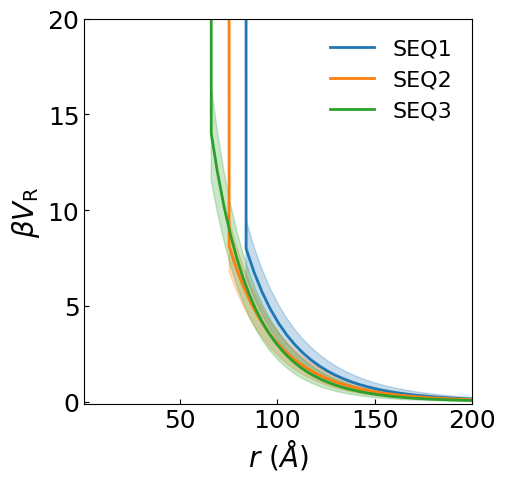

In [6]:
seq_list = ['SEQ1', 'SEQ2', 'SEQ3']

fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

color_list = ['C0', 'C1', 'C2', 'C3', 'C4']

rr = np.linspace(0.01, 10.0, 200)
ur_hc = 4 * 500 * ((2**(1/6) / rr)**12 - (2**(1/6) / rr)**6 - 0.25)
ur_hc[rr >= 1] = 0

# Load the results from the JSON file
with open('results_dict.txt', 'r') as file:
    results_dict = json.load(file)

for i, seq in enumerate(seq_list):
    filename = f'../data/semidilute-anionic/{seq}-anionic-semi/EHT-CVSANS-{seq}-anionic-semi-100.dat'
    data = np.loadtxt(filename, skiprows=2)
    q_data = data[:, 0]
    I_data = data[:, 1]
    I_data_err = data[:, 2]
    q_data_err = data[:, 3]

    # Extract the fitted parameters and covariance matrix for the current sequence
    params_fit = {key: float(str(value).split('value=')[1].split(' +/-')[0]) for key, value in results_dict[seq]['params_fit'].items()}
    cov = np.array(results_dict[seq]['cov'])

    # Convert params_fit to a dictionary
    fp = [params_fit['phi'], params_fit['kappa'], np.log(params_fit['A'])]
    cov = np.array(results_dict[seq]['cov'])

    # Calculate the standard deviation from the covariance matrix
    fp_std = np.sqrt(np.diag(cov))

    ur_NN, ur_NN_std = sample_potential(fp, fp_std)
    
    sigma = params_fit['sigma']

    ax.fill_between(rr*sigma, ur_NN + ur_NN_std, ur_NN - ur_NN_std, color=color_list[i], alpha=0.25)
    ax.plot(rr*sigma, ur_NN, color=color_list[i], label=f'{seq}', lw=2)

ax.set_xlim(0.85, 200)
ax.set_ylim(-0.1, 20)
ax.set_xlabel(r'$r\ (\AA)$', fontsize=20)
ax.set_ylabel(r'$\beta V_\mathrm{R}$', fontsize=20)

# ax.set_yscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax.legend(fontsize=16, frameon=False)

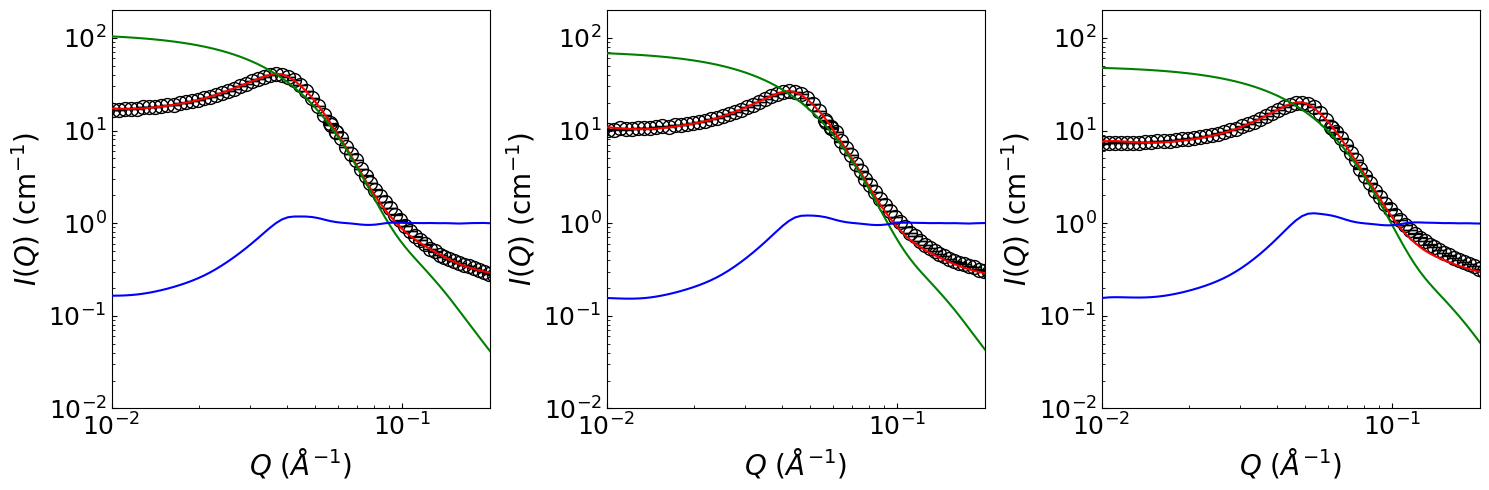

In [7]:
seq_list = ['SEQ1', 'SEQ2', 'SEQ3']

fig = plt.figure(figsize=(15, 5))


color_list = ['C0', 'C1', 'C2', 'C3', 'C4']

# Load the results from the JSON file
with open('results_dict.txt', 'r') as file:
    results_dict = json.load(file)
    
for i, seq in enumerate(seq_list):
    filename = f'../data/semidilute-anionic/{seq}-anionic-semi/EHT-CVSANS-{seq}-anionic-semi-100.dat'
    data = np.loadtxt(filename, skiprows=2)
    q_data = data[:, 0]
    I_data = data[:, 1]
    I_data_err = data[:, 2]
    q_data_err = data[:, 3]

    # Extract I_fit
    I_fit = results_dict[seq]['I_fit']
    Q_fit = results_dict[seq]['S_fit']
    P_fit = results_dict[seq]['P_fit']
    S_fit = results_dict[seq]['S_fit']
    
    ax = plt.subplot(1, 3, i+1)
    ax.errorbar(q_data, I_data, yerr=I_data_err, fmt='ok', markersize=10, label=r'$I_\mathrm{exp}(Q)$', fillstyle='none', capsize=5)  
    ax.plot(q_data, I_fit, 'r-', zorder=10)
    ax.plot(q_data, P_fit, 'g-', label=r'$CP(Q)$', zorder=10)
    ax.plot(q_data, S_fit, 'b-', label=r'$S(Q)$', zorder=10)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([0.01, 0.2])
    ax.set_ylim([1e-2, 2e2])  
    
    ax.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
    ax.set_ylabel(r'$I(Q)\ (\mathrm{cm}^{-1})$', fontsize=20)

    # ax.set_yscale('log')
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
    
plt.tight_layout()

seq = SEQ1
seq = SEQ2
seq = SEQ3


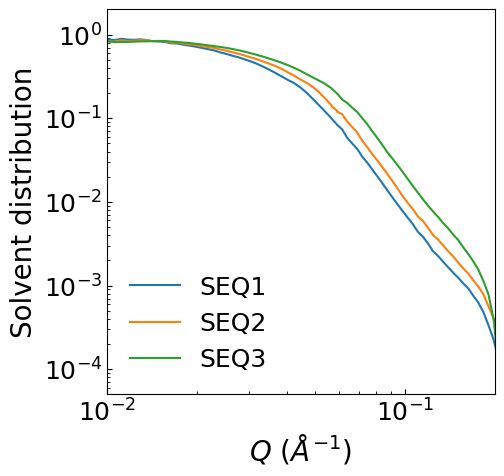

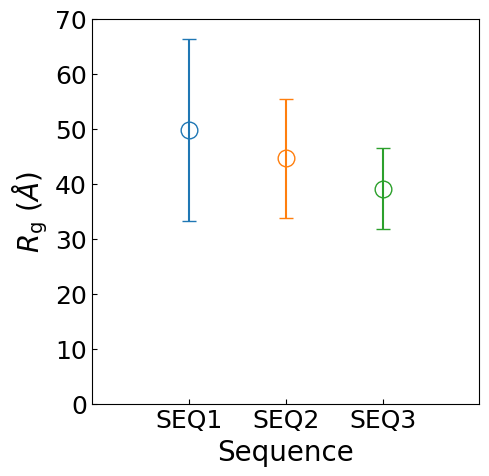

In [8]:
# summarize results
# read the results from results_dict_cvsans
with open('results_dict_cvsans.txt', 'r') as file:
    results_dict_cvsans = json.load(file)

fig1 = plt.figure(figsize=(5,5))
ax1 = fig1.add_subplot(111) 

fig2 = plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111) 
for i_seq, seq in enumerate(seq_list):
    print('seq = {}'.format(seq))
    
    Q_fit = np.array(results_dict_cvsans[seq]['Q_fit'])
    P_alpha_beta = np.array(results_dict_cvsans[seq]['P_alpha_beta'])
    list_I_0 = np.array(results_dict_cvsans[seq]['list_I_0'])
    list_R_g = np.array(results_dict_cvsans[seq]['list_R_g'])
    list_dR_g = np.array(results_dict_cvsans[seq]['list_dR_g'])
    
    ax1.plot(Q_fit, P_alpha_beta[0]/list_I_0[0], label=seq, color=colors[i_seq])
    
    ax2.errorbar(i_seq, list_R_g[0], yerr=list_dR_g[0], fmt='o', markersize=12, capsize=5, fillstyle='none', label=seq, color=colors[i_seq])
    
    
    
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim([5e-5, 2])
ax1.set_xlim([0.01, 0.2])

ax1.set_xlabel(r'$Q\ (\AA^{-1})$', fontsize=20)
ax1.set_ylabel('Solvent distribution', fontsize=20)
ax1.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax1.legend(fontsize=18, loc='best', frameon=False)

# ax2.set_xscale('log')
# ax2.set_yscale('log')
ax2.set_ylim([0, 70])
ax2.set_xlim([-1, len(seq_list)])

ax2.set_xticks(np.arange(len(seq_list)))
ax2.set_xticklabels(seq_list, fontsize=18)

ax2.set_xlabel(r'Sequence', fontsize=20)
ax2.set_ylabel(r'$R_\mathrm{g}\ (\AA)$', fontsize=20)
ax2.tick_params(direction='in', axis='both', which='both', labelsize=18)
# ax2.legend(fontsize=18, loc='best', frameon=False)
    